### Fitting planetary orbits

Fitting an exoplanet data taken from Arxiv to a model of Kepler orbits


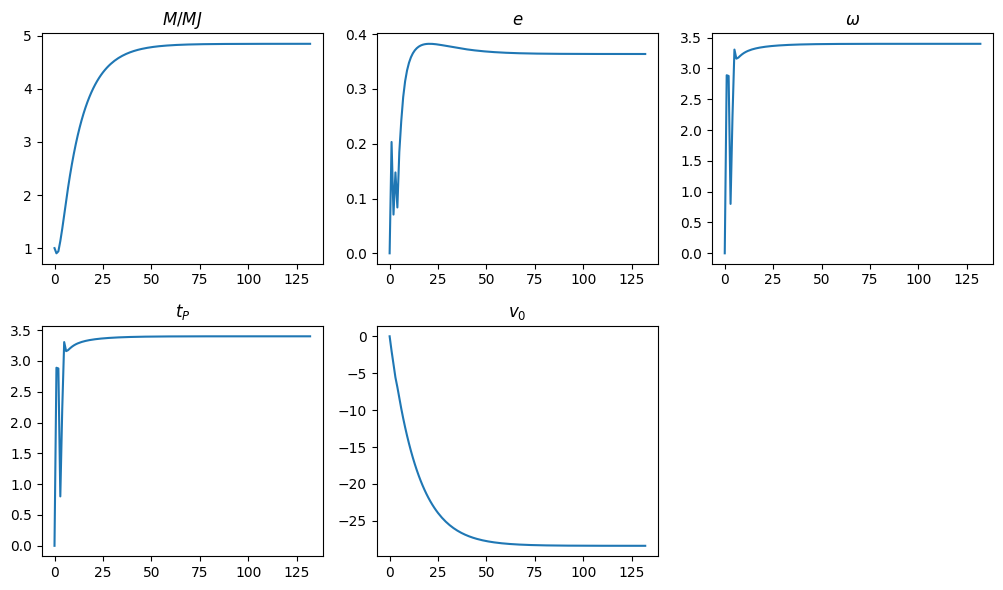

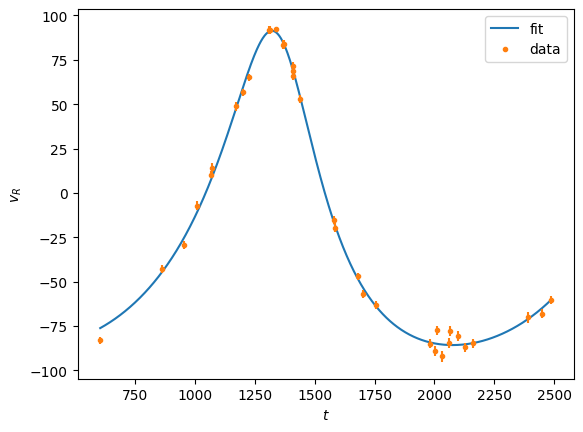

In [5]:
import numpy as np
import scipy.linalg as sllg 
import matplotlib.pyplot as plt

# importind data:

tobs, vobs, eobs = np.loadtxt('rvs.txt', unpack=True)
P = 1724


# This function is imported from class exercise to calculate velocity of star at given time

def rv(t, P, x):
    # Calculates the radial velocity of a star orbited by a planet
    # at the times in the vector t
    
    # extract the orbit parameters
    # P, t and tp in days, mp in Jupiter masses, v0 in m/s  
    mp, e, omega, tp, v0 = x
        
    # mean anomaly
    M = 2*np.pi * (t-tp) / P
    
    # velocity amplitude
    K = 204 * P**(-1/3) * mp  / np.sqrt(1.0-e*e) # m/s
    
    # solve Kepler's equation for the eccentric anomaly E - e * np.sin(E) = M
    # Iterative method from Heintz DW, "Double stars", Reidel, 1978
    # first guess
    E = M + e*np.sin(M)  + ((e**2)*np.sin(2*M)/2)
    while True:
        E0 = E 
        M0 = E0 - e*np.sin(E0)
        E = E0 + (M-M0)/(1.0 - e*np.cos(E0))
        if np.max(np.abs((E-E0))) < 1e-6:
            break
        
    # evaluate the velocities
    theta = 2.0 * np.arctan( np.sqrt((1+e)/(1-e)) * np.tan(E/2))
    vel = v0 + K * ( np.cos(theta + omega) + e * np.cos(omega))
    return vel



# This function is to calculate the A matrix of a certain set of x (5 parameters)
# Using finite differentiation method
def get_matrix_A(t, P, x):
    
    # Construct empty matrix A
    A =  np.zeros([len(t), len(x)])
    eps = 1e-7                       # Small changes in x
    velo = rv(t, P, x)               # local value of velocity evaluated at x

    # change x values one by one, and code their dv/dx in matrix A
    v_mp = rv(t, P, x = x + np.array([eps, 0, 0, 0, 0]))
    A[:, 0] = (v_mp - velo)/(eps)

    v_e = rv(t, P, x = x + np.array([0, eps, 0, 0, 0]))
    A[:, 1] = (v_e - velo)/(eps)

    v_omega = rv(t, P, x = x + np.array([0, 0, eps, 0, 0]))
    A[:, 2] = (v_omega - velo)/(eps)

    v_tp = rv(t, P, x = x + np.array([0, 0, 0, eps, 0]))
    A[:, 3] = (v_tp - velo)/(eps)

    v_v0 = rv(t, P, x = x + np.array([0, 0, 0, 0, eps]))
    A[:, 4] = (v_v0 - velo)/(eps)

    return velo, A                  # for convenience, velo is calculated anyway

# chi-square function
def chi_square (x, tobs, vobs, eobs):
    chisq = np.sum(((vobs-rv(tobs, P, x))/eobs)**2)
    return chisq


# Initial guess   
x = np.array([1.0, 0.0, 0.0, 0.0, 0.0])
# create an array to track the change of x
x_history = np.array([x])


err = 0.0
alpha = 0.2
lam = 0.001


# implement Levenberg-Marquardt methods
timesteps = 250
for i in range(timesteps):

    f, AAA = get_matrix_A(tobs, P, x)
    res = (vobs - f) / eobs
    chi2 = chi_square(x, tobs, vobs, eobs)

    # perpose a try with newton method, modified by lambda
    x_try = alpha * np.linalg.inv(AAA.T @ AAA @ (np.identity(5)*(1+lam))) @ (AAA.T @ res)

    if chi_square(x + x_try, tobs, vobs, eobs) < chi2:    # jump
        x += x_try
        x_history = np.insert(x_history, 0, x, axis= 0)   # store x history value ***
        lam = 0.1 * lam

    if chi_square(x + x_try, tobs, vobs, eobs) > chi2:    # no jump
        lam = 10 * lam
    
    # break loop when reaching desired precision
    err =np.sqrt(np.mean(res**2))
    if np.sqrt(np.mean(res**2)) <= 0.000001:
        break


t = np.linspace(tobs[0], tobs[-1], 1000)


# because of the way how I update x-his is np.insert see ***
# putting the new value in front of the old one, thus, I need to reverse it at the end
x_history = x_history[::-1]

# adjust omega, entricity, t_P
x_historyy = x_history.copy()
x_historyy[:, 1] = -1 * x_history[:, 1] 
x_historyy[:, 2] = x_history[:, 2]%(2*np.pi)   # clear extra phase
x_historyy[:, 3] = x_history[:, 2]%(2*np.pi)

plt.figure(figsize=(10,6))
titles = (r'$M/MJ$', r'$e$', r'$\omega$', r'$t_P$', r'$v_0$')
for i, title in enumerate(titles):
    plt.subplot(2,3,i+1)
    plt.title(title)
    plt.plot(list(range(len(x_historyy))), x_historyy[:, i])
plt.tight_layout()
plt.show()



# plot the fit results
plt.plot(t, rv(t,P, x), 'C0', label ="fit")
plt.plot(tobs, vobs, 'C1.', label = "data")
plt.errorbar(tobs, vobs, eobs, fmt='none', ecolor='C1')
plt.legend()
plt.ylabel(r'$v_{R}$')
plt.xlabel(r'$t$')
plt.show()

Diference between Lueven method and MCMC

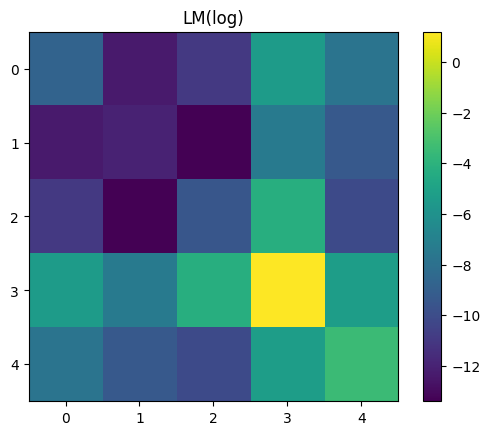

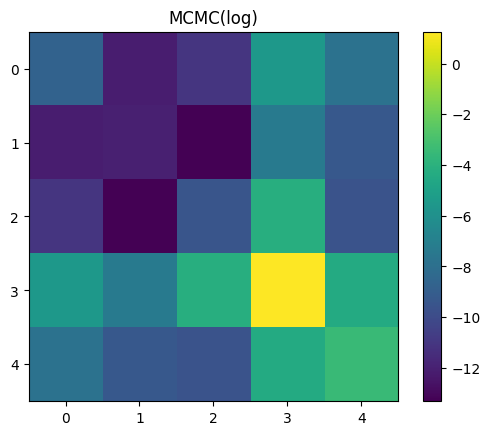

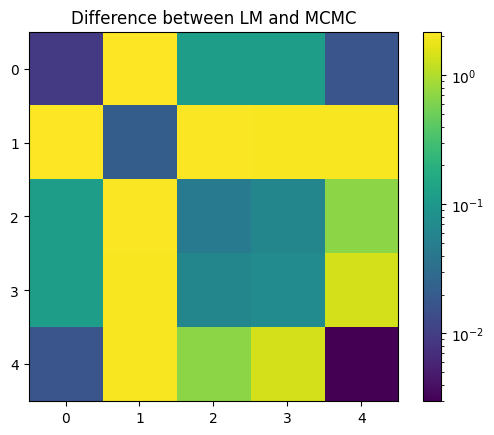

In [6]:
from matplotlib import colors
# the covariance matrix for best fit with LM method:

ff, AA = get_matrix_A(tobs, P, x)

LMC = np.linalg.inv(AA.T @ AA)
lmc_log = np.log(np.abs(LMC))


plt.imshow(lmc_log)
plt.colorbar()
plt.title("LM(log)")
plt.show()


# for MCMC:
# the results are imported
xxx = np.array([ 4.83846322e+00,  3.60694725e-01,  3.04891515e-01, -3.58669506e+02, -2.79063903e+01])

ffff, AAAA = get_matrix_A(tobs, P, xxx)

MCMCC = np.linalg.inv(AAAA.T @ AAAA)
mcmc_log = np.log(np.abs(MCMCC))

plt.imshow(mcmc_log) 
plt.title("MCMC(log)")
plt.colorbar()
plt.show()


plt.imshow(np.abs((MCMCC - LMC)/LMC), norm=colors.LogNorm())
plt.colorbar()
plt.title("Difference between LM and MCMC")
plt.show()
